# Quantifying Event Features using Computational Methods 

Tone of the event: Sentiment scoring (positive, negative, neutral)
Controversy Level: Number of comments, polarity of responses.
Recency Effect: How past similar events influence reactions (does frequency dampen or amplify engagement?).

In [1]:
!pip install pandas numpy textblob vaderSentiment transformers datasets nltk scipy


In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from datetime import datetime
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from transformers import pipeline

# Initialize sentiment analysis tools
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=False)

# Load Data
post_df = pd.read_csv("merged_posts.csv")  # Replace with actual file path
comment_df = pd.read_csv("merged_comments.csv")  # Replace with actual file path

# Convert timestamps to datetime
post_df["created_time"] = pd.to_datetime(post_df["created_time"])
comment_df["com_created_time"] = pd.to_datetime(comment_df["com_created_time"])
comment_df["sub_created_time"] = pd.to_datetime(comment_df["sub_created_time"])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Device set to use cuda:0
/opt/conda/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [2]:
 # Extract Feature 1 - Tone of the Event (Sentiment & Emotion). Sentiment score: Ranges from -1 (negative) to +1 (positive)

# Function to get sentiment score
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment["compound"]  # Compound sentiment score (-1 to 1)

# Function to get emotion label with safe truncation
def get_emotion(text):
    max_length = 500  # Ensure it stays within model limits
    truncated_text = text[:max_length]  # Truncate long texts
    try:
        emotions = emotion_classifier(truncated_text)  
        return emotions[0]["label"]  # Return the most probable emotion
    except Exception as e:
        return "error"  # Return a default label if something fails

# Apply sentiment & emotion analysis
post_df["sentiment_score"] = post_df["selftext"].astype(str).apply(get_sentiment)
post_df["emotion_label"] = post_df["selftext"].astype(str).apply(get_emotion)

# Display results
post_df[["post_id", "sentiment_score", "emotion_label"]].head()


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors
../aten/src/ATen/native/cuda/Indexing.cu:1308: indexSelectLargeIndex: block: [388,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1308: indexSelectLargeIndex: block: [388,0,0], thread: [33,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1308: indexSelectLargeIndex: block: [388,0,0], thread: [34,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1308: indexSelectLargeIndex: block: [388,0,0], thread: [35,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1308: indexSelectLargeIndex: block: [388,0,0], thread: 

,post_id,sentiment_score,emotion_label
0,v2gscr,-0.8095,neutral
1,v2gww2,-0.9994,fear
2,v2hnxi,0.9045,disgust
3,v2hr1o,0.9691,neutral
4,v2i178,0.9724,anger


In [3]:
# Extract Feature 2 - Controversy Level (Engagement & Disagreement Patterns)

# Function to calculate disagreement rate
def calculate_controversy(post_id, post_stance):
    comments = comment_df[comment_df["parent_id"] == post_id]
    opposing_comments = comments[comments["com_stance_fin"] != post_stance]  # Disagreeing comments
    if len(comments) == 0:
        return 0  # No comments means 0 controversy
    return len(opposing_comments) / len(comments)  # % disagreement

# Apply controversy score calculation
post_df["controversy_score"] = post_df.apply(lambda row: calculate_controversy(row["post_id"], row["stance"]), axis=1)

# Compute Engagement Index
post_df["engagement_index"] = np.log1p(post_df["num_comments"]) * post_df["score"].std()

# Display results
post_df[["post_id", "controversy_score", "engagement_index"]].head()


,post_id,controversy_score,engagement_index
0,v2gscr,0.0,499.703941
1,v2gww2,0.0,0.000000
2,v2hnxi,0.0,0.000000
3,v2hr1o,0.0,0.000000
4,v2i178,0.0,630.556169


In [4]:


# Extract Feature 3 - Recency of Similar Events (Event Memory Effect)
# How much time has passed since the last similar event?
# Does engagement drop for repeated topics?


# Function to calculate recency index
def get_recency(post_time, stance, window_days=30):
    past_events = post_df[
        (post_df["created_time"] < post_time) &  # Older posts only
        (post_df["stance"] == stance)  # Same stance
    ]
    if past_events.empty:
        return np.nan  # No past similar event
    last_event_time = past_events["created_time"].max()
    return (post_time - last_event_time).days  # Days since last similar post

# Apply event recency calculation
post_df["event_recency_index"] = post_df.apply(lambda row: get_recency(row["created_time"], row["stance"]), axis=1)

# Display results
post_df[["post_id", "event_recency_index"]].head()


,post_id,event_recency_index
0,v2gscr,0.0
1,v2gww2,0.0
2,v2hnxi,0.0
3,v2hr1o,0.0
4,v2i178,0.0


In [5]:
post_df.to_csv("processed_posts_with_event_features_all.csv", index=False)


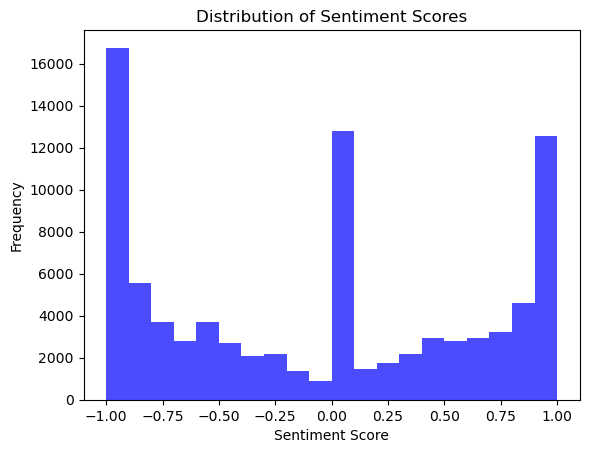

In [6]:
plt.hist(post_df["sentiment_score"], bins=20, color="blue", alpha=0.7)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Scores")
plt.show()


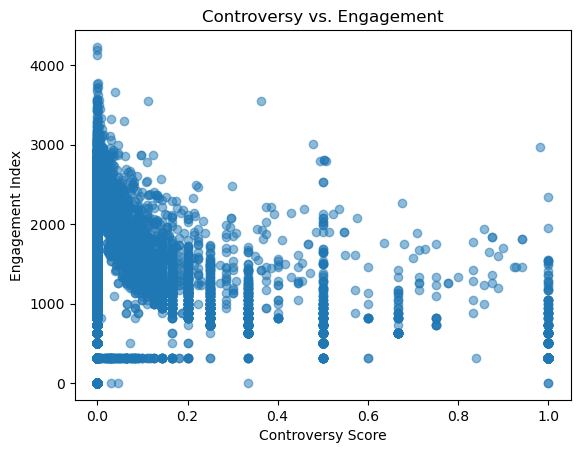

In [7]:
plt.scatter(post_df["controversy_score"], post_df["engagement_index"], alpha=0.5)
plt.xlabel("Controversy Score")
plt.ylabel("Engagement Index")
plt.title("Controversy vs. Engagement")
plt.show()
